# Data Pre-processing

__Running this notebook will produce a json file with the census tracts that are 50 miles away from each other as well as a csv file containing the number of universities accessible by each census tract and whether or not it is an education desert__

---
## Data Mining
__In this section we will read in census tract data, representing each cenus tract as a graph node with location of node at the centroid of the polygon__

In [1]:
# Library Imports
import fiona 
import rtree
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np
import subprocess
import os
import requests
from bs4 import BeautifulSoup
import seaborn as sns
sns.set(style="ticks")

# Output Images Settings
from pylab import rcParams
rcParams['figure.figsize'] = 14, 14

# default dictionary (a dictionary with a default value if a key doesn't exist)
from collections import defaultdict

# To unzip file
import zipfile

# To have progress bar
from tqdm import tqdm
import json

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
%matplotlib inline

# Constants
BUFFER = 1609.34 # 1 mile in metres

# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

In [2]:
with fiona.Env():
    ds = fiona.open('./datasets/census_tracts/Alabama/')
    print(ds.crs)

{'init': 'epsg:4269'}


---
## Datasets

In [3]:
# Census tracts shapefiles url
ct_shape_url = 'https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html'

# Census tracts data url from 2012 - 2017
ct_file_name = 'acs_5_year_estimates_census_tracts.csv'
ct_data_url = 'https://www.dropbox.com/s/ni28x7mw6uh00dg/' + ct_file_name + '.zip?dl=1'

# American University Data
au_file_name = 'IPEDS_data.xlsx'
au_data_url = 'https://public.tableau.com/s/sites/default/files/media/Resources/' + au_file_name

# Directory of datasets
DATASETS_PATH = 'datasets/'

# Directory of census tract shapefile data
CENSUS_TRACTS_PATH = DATASETS_PATH + 'census_tracts/'

# Make the directory for the census tracts shapefiles data
mkdir(DATASETS_PATH)

# Remove any old data for census tracts shapefiles
# subprocess.call(['rm', '-rf', CENSUS_TRACTS_PATH])

(datasets/) already exists


### Census Tract Data

__Census Tracts have a population of around ${2,500}$ - ${8,000}$ people__

In [4]:
# Download data 
if not os.path.isfile(DATASETS_PATH + ct_file_name):
    
    os.system('!wget --directory-prefix={} -Nq {}'.format(DATASETS_PATH, ct_data_url))
    
    # Unzipping the file
    zip_ref = zipfile.ZipFile(DATASETS_PATH + ct_file_name + '.zip', 'r')
    zip_ref.extractall(DATASETS_PATH + ct_file_name + '/')
    zip_ref.close()
    
    # Remove the old census tract .zip shapefile
    subprocess.call(['rm', '-rf', DATASETS_PATH + ct_file_name + '.zip'])

In [5]:
# Let's take a look at the census tract data
census_tracts = pd.read_csv(DATASETS_PATH + ct_file_name, encoding='ISO-8859-1', low_memory=False)
census_tracts.head()

,FIPS,Geographic Identifier,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),Summary Level,Geographic Component,File Identification,Logical Record Number,US,...,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months Below Poverty Level: Male: in Labor Force: Employed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months Below Poverty Level: Male: in Labor Force: Unemployed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months Below Poverty Level: Male: Not in Labor Force,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: in Labor Force,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: in Labor Force: Employed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: in Labor Force: Unemployed,Civilian Population 16 Years and Over for Whom Poverty Status Is Determined: Income in the Past 12 Months At or Above Poverty Level: Male: Not in Labor Force,Households.1,Households with Housing Costs more than 30% of Income
0,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,...,SE_T254_004,SE_T254_005,SE_T254_006,SE_T254_007,SE_T254_008,SE_T254_009,SE_T254_010,SE_T254_011,SE_T255_001,SE_T255_002
1,01001020100,14000US01001020100,"Census Tract 201, Autauga County, Alabama","Census Tract 201, Autauga County, Alabama",al,140,00,ACSSF,0001766,NaN,...,36,7,80,1360,880,845,35,480,754,144
2,01001020200,14000US01001020200,"Census Tract 202, Autauga County, Alabama","Census Tract 202, Autauga County, Alabama",al,140,00,ACSSF,0001767,NaN,...,59,0,204,1230,823,793,30,407,783,218
3,01001020300,14000US01001020300,"Census Tract 203, Autauga County, Alabama","Census Tract 203, Autauga County, Alabama",al,140,00,ACSSF,0001768,NaN,...,61,3,305,2291,1491,1421,70,800,1279,357
4,01001020400,14000US01001020400,"Census Tract 204, Autauga County, Alabama","Census Tract 204, Autauga County, Alabama",al,140,00,ACSSF,0001769,NaN,...,16,0,66,3241,1953,1833,120,1288,1749,361


### American University Data

In [6]:
# Download data 
if not os.path.isfile(DATASETS_PATH + au_file_name):
    
    os.system('!wget --directory-prefix={} -Nq {}'.format(DATASETS_PATH, au_data_url))

In [7]:
# Let's take a look at the american university data
universities = pd.read_excel(DATASETS_PATH + au_file_name, index_col='ID number')
universities.head()

,Name,year,ZIP code,Highest degree offered,County name,Longitude location of institution,Latitude location of institution,Religious affiliation,Offers Less than one year certificate,Offers One but less than two years certificate,...,Percent of freshmen receiving federal grant aid,Percent of freshmen receiving Pell grants,Percent of freshmen receiving other federal grant aid,Percent of freshmen receiving state/local grant aid,Percent of freshmen receiving institutional grant aid,Percent of freshmen receiving student loan aid,Percent of freshmen receiving federal student loans,Percent of freshmen receiving other loan aid,Endowment assets (year end) per FTE enrollment (GASB),Endowment assets (year end) per FTE enrollment (FASB)
ID number,,,,,,,,,,,,,,,,,,,,,
100654,Alabama A & M University,2013,35762,Doctor's degree - research/scholarship,Madison County,-86.568502,34.783368,Not applicable,Implied no,Implied no,...,81.0,81.0,7.0,1.0,32.0,89.0,89.0,1.0,NaN,NaN
100663,University of Alabama at Birmingham,2013,35294-0110,Doctor's degree - research/scholarship and pro...,Jefferson County,-86.809170,33.502230,Not applicable,Implied no,Yes,...,36.0,36.0,10.0,0.0,60.0,56.0,55.0,5.0,24136.0,NaN
100690,Amridge University,2013,36117-3553,Doctor's degree - research/scholarship and pro...,Montgomery County,-86.174010,32.362609,Churches of Christ,Implied no,Implied no,...,90.0,90.0,0.0,40.0,90.0,100.0,100.0,0.0,NaN,302.0
100706,University of Alabama in Huntsville,2013,35899,Doctor's degree - research/scholarship and pro...,Madison County,-86.638420,34.722818,Not applicable,Yes,Implied no,...,31.0,31.0,4.0,1.0,63.0,46.0,46.0,3.0,11502.0,NaN
100724,Alabama State University,2013,36104-0271,Doctor's degree - research/scholarship and pro...,Montgomery County,-86.295677,32.364317,Not applicable,Implied no,Implied no,...,76.0,76.0,13.0,11.0,34.0,81.0,81.0,0.0,13202.0,NaN


In [8]:
len(universities)

1534

### University Points Dictionary
__Let's store the IDs and Location (Lat, Long) of the universities as Shapely Point objects in dictionary__

In [9]:
for idx, id_num in enumerate(universities.index):
    print(idx)
    print(id_num)
    break

0
100654


In [10]:
from shapely.geometry import shape

# List of tuples to store all the university
# locations as Shapely Points
uni_list = []

for idx, id_num in enumerate(universities.index):
    uni_list.append((id_num, shape({"type": "Point",
                                    "coordinates": (universities.loc[id_num, 'Longitude location of institution'],
                                                    universities.loc[id_num, 'Latitude location of institution'])})))

for x in uni_list:
    print(x)
    break

(100654, <shapely.geometry.point.Point object at 0x1a246f9a58>)


### Saving Data

__Courtesy of Caleb Robinson:__

This article is a very good discussion of what coordinate reference systems (CRSs) are and why we need them, you should probably read it as a starting point: https://docs.qgis.org/testing/en/docs/gentle_gis_introduction/coordinate_reference_systems.html

 

- Every piece of geographic data will have a CRS. Aaron showed how to see the CRS of shapefiles in Tuesday's lecture, so you can see that notebook for an example of how to find the CRS that your data is in.

- Once you have the CRS of your data, then you can look it up on epsg.io to see what units it is in. If you are using Census Tract shapefiles from TIGER then your data will most likely be in EPSG:4269, which has the units of degrees.

- The conversion rate from degrees --> km or degrees --> miles changes based on the latitude. For example, 1 degree of latitude is ~68.71 miles at the equator but it is ~68.99 miles at 40 degrees N. Similarly, a degree of longitude is 69.17 at the equator but just 53.06 miles at 40 degrees N.

- This means you need to convert your data into an equal area coordinate system that has been specifically designed to represent distances equally. This is of course impossible to do for the entire globe, which is why these coordinate systems are local to different areas (and why big states like California can have many different coordinate systems, different coordinate systems will let you represent distances with different degrees of precision).

- One such equal area CRS is the U.S. National Atlas Equal Area Projection - EPSG:2163. You should probably use this.

- If you need a realllly high degree of accuracy (for example in the land cover mapping project that I presented - 1m differences matter) then read about the US State Plane Coordinate System - https://en.wikipedia.org/wiki/State_Plane_Coordinate_System. Here, clever people have defined a bunch of coordinate systems (like, over 100) that tile the US and give high degrees of accuracy. This is hard to use for US wide projects.

- See the internet/notebook from Tuesday/office hours for how to actually convert your data into EPSG:2163.

### Changing Coordinate System for Universities

__Old University Equal Area CRS__

In [11]:
# Setting our coordinate system for the tracts 
# and universities to EPSG:2163 https://epsg.io/2163
uni_gdf = gpd.GeoDataFrame(geometry=[uni_pt for uniid, uni_pt in uni_list], index=[uniid for uniid, uni_pt in uni_list])
uni_gdf.crs = {'init': 'epsg:4269'}
uni_gdf.to_crs({'init': 'epsg:2163'}, inplace=True);

__New University Equal Area CRS__

In [12]:
uni_gdf.head()

,geometry
100654,POINT (1225201.891594255 -1037087.540014169)
100663,POINT (1223240.312223427 -1181383.792952623)
100690,POINT (1299587.523129071 -1297132.337559302)
100706,POINT (1219845.437091383 -1044756.037902317)
100724,POINT (1288245.395679843 -1298787.753572568)


__Universities Plot__

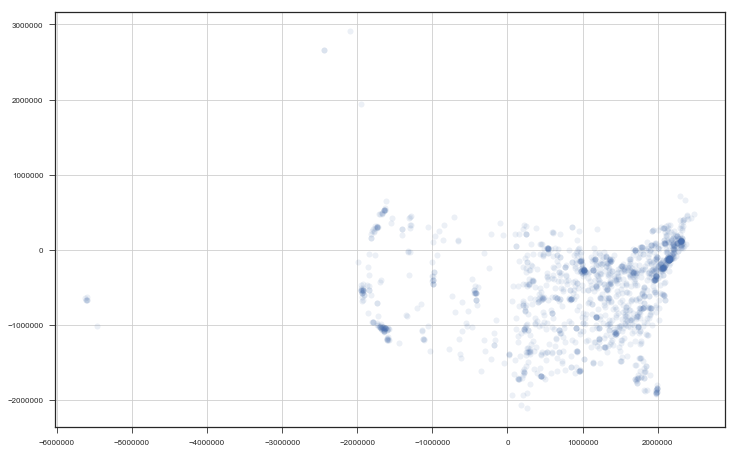

In [13]:
uni_gdf.plot(figsize=(12, 8), alpha=0.1)
plt.grid();

### University RTree Index
__Let's store the IDs and Location (Lat, Long) of the universities in an RTree Index__

In [14]:
# ----------------------------
# Initialize rtree spatial index
# with just its centroid
uni_index = rtree.index.Index()

# Iterate over all american universities
for idx, (id_num, uni) in tqdm(enumerate(uni_gdf.iterrows())):
    
    # add coordinates of univeristy location and store id along with it
    uni_index.insert(idx, coordinates=uni.geometry.bounds, obj=id_num)

    # we can now query this datastructure with a point and it will tell us which 
    # polygon it lies in
    
# ----------------------------
# Initialize rtree spatial index
# with a buffer around each
# university
uni_buffer_index = rtree.index.Index()

# Iterate over all american universities
for idx, (id_num, uni) in tqdm(enumerate(uni_gdf.iterrows())):
    
    # add coordinates of univeristy location and store id along with it
    uni_buffer_index.insert(idx, coordinates=uni.geometry.buffer(BUFFER).bounds, obj=id_num)

    # we can now query this datastructure with a point and it will tell us which 
    # polygon it lies in

1534it [00:00, 6198.33it/s]
1534it [00:00, 4354.22it/s]


---
## Census Tract Shape Files

In [15]:
# Make request to get the webpage
r = requests.get(ct_shape_url)
soup = BeautifulSoup(r.content, "html.parser")

# Get the download links from the dropdown <option> tag
locations = soup.find('select',
                      {'name':'Location',
                       'id':'ct2017m'}).findChildren('option' , recursive=False)[1:]

# Put all the states and the urls for their shape files in a dictionary
state_urls = {location.text.strip() : location.attrs['value'] for location in locations}

In [16]:
# Download data 
if not os.path.isdir(CENSUS_TRACTS_PATH):
    
    # Make the directory for the census tracts shapefiles data
    mkdir(CENSUS_TRACTS_PATH)
    
    for state, state_url in state_urls.items():
        os.system('wget --directory-prefix={} -Nq {}'.format(CENSUS_TRACTS_PATH, state_url))
        
    # Storing the shape file names
    census_tract_shapefiles = []
    for state, state_url in state_urls.items():

        # Extracting the name of shapefile
        shapefile = state_url[state_url.rindex('/') + 1:]
        census_tract_shapefiles.append(shapefile)

        # Renaming the file
        os.rename(CENSUS_TRACTS_PATH + shapefile, CENSUS_TRACTS_PATH + state + '.zip')

        # Unzipping the file
        zip_ref = zipfile.ZipFile(CENSUS_TRACTS_PATH + state + '.zip', 'r')
        zip_ref.extractall(CENSUS_TRACTS_PATH + state + '/')
        zip_ref.close()

        # Remove the old census tract .zip shapefile
        subprocess.call(['rm', '-rf', CENSUS_TRACTS_PATH + state + '.zip'])

### Census Tract Centroid Points Dictionary
__Let's store the geoIDs and Location (Lat, Long) of the census tract centroids as Shapely Point objects in dictionary__

In [17]:
# Shapely library to help with calculation
# of the representative centroid position
from shapely.geometry import MultiPoint

# ----------------------------
# Let's calculate and store each of 
# the centroids of each
# census tract in a list of tuples
tract_centroids = []

# ----------------------------
# Let's store a list of each census 
# tract's geometry as well
tract_list = []
    
for subdir, dirs, files in list(os.walk(CENSUS_TRACTS_PATH))[1:]:
    
    # Opening the shapefile
    state_shapes = fiona.open(subdir, 'r')
#     state_shapes = gpd.read_file(subdir)
    
    # Looping through each census tract in each state and 
    # making key: geoid, value: centroid position
    # of (longitude, latitude) as well as building the 
    # RTree index for census tracts
    for idx, census_tract in enumerate(state_shapes):
        
        geoid = census_tract['properties']['GEOID']
        geometry = np.array(census_tract['geometry']['coordinates'])
        points = None
        
        # Some of the geometries are in a 2d and some in 3d array
        if len([True for lat_long in geometry[0] if len(lat_long) != 2]) > 0:
            
            # Create the Multipoint object to find centroid
            points = MultiPoint(geometry[0][0])
            
        else:
            
            # Create the Multipoint object to find centroid
            points = MultiPoint(geometry[0])
        
        # ----------------------------
        # Create Census tract Polygon
        tract = shapely.geometry.shape(census_tract['geometry'])
        
        # ----------------------------
        # Store the Census tract Polygon
        # in our list for the RTree index
        # later on
        tract_list.append((geoid, tract))
        
        # ----------------------------
        # Create Census tract Centroid
        # True centroid, not necessarily an existing point
        centroid_pt = points.centroid
        
        # A represenative point, not centroid,
        # that is guarnateed to be with the geometry
        tract_centroids.append((geoid, shapely.geometry.shape(points.representative_point())))

In [18]:
# Number of census tracts
len(tract_centroids)

73874

In [19]:
for x in tract_centroids:
    print(x)
    break

('29001950900', <shapely.geometry.point.Point object at 0x1a245ded68>)


__TODO: Problem with shape of the geometry, I thought it was supposed to be a list of size=2 tuples.__

__UPDATE: I reduced the 3D and 2D arrays to 1D, hopefully I didn't miss information__

### Changing coordinate system for Census Tracts

__Old Census Tract Equal Area CRS__

In [20]:
# Setting our coordinate system for the tracts 
# and universities to EPSG:2163 https://epsg.io/2163
tract_gdf = gpd.GeoDataFrame(geometry=[tract_shape for geoid, tract_shape in tract_list], index=[geoid for geoid, tract_pt in tract_list])
tract_gdf.crs = {'init': 'epsg:4269'}
tract_gdf.to_crs({'init': 'epsg:2163'}, inplace=True)

tract_centroids_gdf = gpd.GeoDataFrame(geometry=[tract_pt for geoid, tract_pt in tract_centroids], index=[geoid for geoid, tract_pt in tract_centroids])
tract_centroids_gdf.crs = {'init': 'epsg:4269'}
tract_centroids_gdf.to_crs({'init': 'epsg:2163'}, inplace=True)

__New Census Tract Equal Area CRS__

In [21]:
tract_gdf.head()

,geometry
29001950900,POLYGON ((629242.0316918371 -506221.3254062997...
29007950100,POLYGON ((726058.4147780467 -594058.6638516618...
29009960100,POLYGON ((549396.9598456144 -886283.8071082532...
29019001201,POLYGON ((657151.3594785809 -643289.4193804697...
29021000600,POLYGON ((441856.9767450066 -565820.0687293162...


__Census Tract Plot__

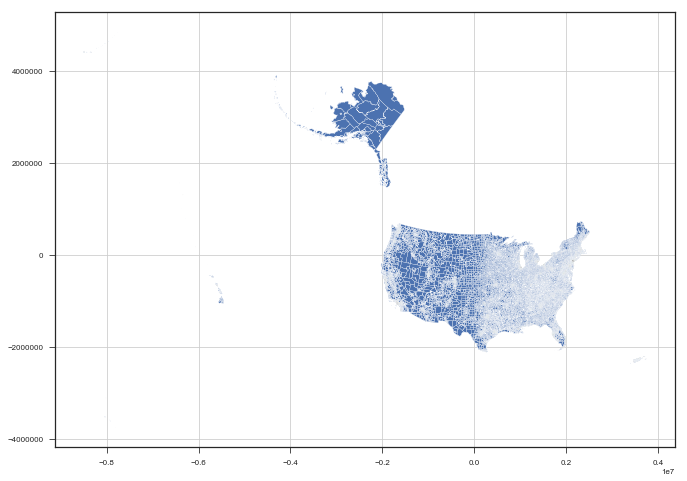

In [22]:
tract_gdf.plot(figsize=(12, 8))
plt.grid();

### Census Tract RTree Index
__Let's store the geoIDs and Location (Lat, Long) of the census tract centroids in an RTree Index__

In [23]:
# ----------------------------
# Initialize rtree spatial index
tract_index = rtree.index.Index()
    
# Iterate over all census tract centroids
for idx, (geoid, tract) in tqdm(enumerate(tract_gdf.iterrows())):
    
    # add coordinates of census tract and store geoid along with it
    tract_index.insert(idx, coordinates=tract.geometry.bounds, obj=geoid)

    # we can now query this datastructure with a point and it will tell us which 
    # polygon it lies in
    
# ----------------------------
# Initialize rtree spatial index
# for census tract centroids with
# CENTROID point bounding box
tract_centroid_index = rtree.index.Index()
    
# Iterate over all census tract centroids
for idx, (geoid, centroid) in tqdm(enumerate(tract_centroids_gdf.iterrows())):
    
    # add coordinates of census tract and store geoid along with it
    tract_centroid_index.insert(idx, coordinates=centroid.geometry.bounds, obj=geoid)

    # we can now query this datastructure with a point and it will tell us which 
    # polygon it lies in
    
# ----------------------------
# Initialize rtree spatial index
# for census tract centroids with
# buffer bounding box
tract_buffer_index = rtree.index.Index()
    
# Iterate over all census tract centroids
for idx, (geoid, centroid) in tqdm(enumerate(tract_centroids_gdf.iterrows())):
    
    # add coordinates of census tract and store geoid along with it
    tract_buffer_index.insert(idx, coordinates=centroid.geometry.buffer(BUFFER).bounds, obj=geoid)

    # we can now query this datastructure with a point and it will tell us which 
    # polygon it lies in

73874it [00:14, 5085.50it/s]
73874it [00:13, 5558.39it/s]
73874it [00:19, 3865.06it/s]


### Census Tract Graph

__We will loop through each census tract and for each census tract, compute it's distance to all other ${n - 1}$ census tracts, storing it in a graph as the edge weights for each census tract node - Essentially creating a ${K_{73,874}}$ Complete Graph__

In [24]:
# Haversine formula to calculate 
# geographical distance between 2 pairs of
# latitude, longitude coordinates
from haversine import haversine

# The Census Tract Graph where each node represents
# a census tract and each edge exists if and only if
# the two census tracts are within 50 miles of each
# other
class CT_Graph:
    
    # The Nodes (Census Tracts)
    class Node:
        def __init__(self, geo_id, coordinates):
            self._geo_id = geo_id
            self._coordinates = coordinates
        
        # US Census Tract Geo ID
        @property
        def geo_id(self):
            return self._geo_id
        
        @geo_id.setter
        def geo_id(self, value):
            self._geo_id = value
        
        # Census tract centroid location 
        # Type: Point
        # Format: (latitude, longitude)
        @property
        def coordinates(self):
            return self._coordinates
        
        @coordinates.setter
        def coordinates(self, value):
            self._coordinates = value
        
    # The Edges (Connections from centroids to centroids)
    class Edge:
        def __init__(self, node_pair, distance):
            self._node_pair = node_pair
            
            # Storing Haversine Distance in miles
            self._distance = distance

        # Tuple of 2 Nodes
        @property
        def node_pair(self):
            return self._node_pair
        
        @node_pair.setter
        def node_pair(self, value):
            self._node_pair = value
        
        # Edge Weight / Haversine Distance
        # between the pairs of lat longs
        @property
        def distance(self):
            return self._distance
        
        @distance.setter
        def distance(self, value):
            self._distance = value
        
    def __init__(self, census_tracts_centroids):
        self._threshold_distance = 50
        self._nodes = []
        self._edges = []
        
        # Creating all my nodes O(n)
        for geo_id, coordinates in census_tracts_centroids.items():
            self._nodes.append(CT_Graph.Node(geo_id, coordinates))
         
        # Creating all my edges O(n^2)
        for idx, node1 in tqdm(enumerate(self._nodes)):
            
            for node2 in self._nodes[idx + 1:]:
                
                # Calculating Haversine Distance
                distance = haversine(*[(node.coordinates.x, node.coordinates.y) for node in (node1, node2)], unit='mi')
                
                # Add the Edge only if Haversine Distance is less than 50 miles
                if distance <= self._threshold_distance:
                    self._edges.append(CT_Graph.Edge((node1, node2), distance))
        
    # List of Census Tract nodes
    @property
    def nodes(self):
        return self._nodes

    @nodes.setter
    def nodes(self, value):
        self._nodes = value

    # List of Census Tract edges
    @property
    def edges(self):
        return self._edges

    @edges.setter
    def edges(self, value):
        self._edges = value

In [25]:
# Initializing Census Tract Graph (THIS WILL TAKE SUPER LONG TO RUN)
# ct_graph = CT_Graph(tract_centroids) 

__Finding out which of the census tracts are 50 miles (80467.2 metres) away from each other__

In [78]:
# Dictionary of Key: GeoID
# Value: List(GeoID)
# Contains which census tract centroids are accessible to 
# that census tract within BUFFER radius
tracts_in_buffer = defaultdict(list)

# 1. Go through each census tract centroid
# 2. Create a BOUNDING BOX of BUFFER radius around that centroid
# 3. Find which centroids are inside that BOX
# 4. Check if that centroid exists in the BUFFER CIRCLE of the census tract 
for idx, (geoid, centroid) in tqdm(enumerate(tract_centroids_gdf.iterrows())):
    
    tracts_in_buffer[geoid] = []
    
    # get iterable (generator) of indices from RTree index of census tracts centroids
    # that are contained within a BUFFER BOX of the current centroid
    # http://toblerity.org/rtree/tutorial.html#intersection
    for overlapping_ind in tract_centroid_index.intersection(centroid.geometry.buffer(BUFFER).bounds):
        
        # Check if current tract centroid's BUFFER CIRCLE
        # contains the overlapping index's CENTROID
        if tract_centroids_gdf.iloc[overlapping_ind].name != geoid and centroid.geometry.buffer(BUFFER).contains(shapely.geometry.shape(tract_centroids_gdf.iloc[overlapping_ind].geometry)):
        
            # add the overlapping_ind's geoID of the census tract into the current census tract's list
            # of census tracts accessible within buffer radius
            tracts_in_buffer[geoid].append(tract_centroids_gdf.iloc[overlapping_ind].name)
            

73874it [02:15, 545.02it/s] 


In [79]:
# Let's take a peak
for x in tracts_in_buffer.items():
    print(x)
    break

('29001950900', ['29001951000', '29001950400'])


__Sanity check on whether we computed the 50 mile radius census tracts correctly__

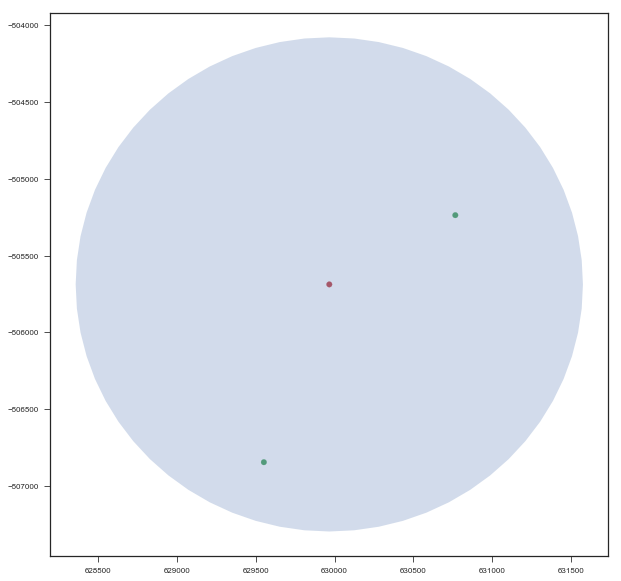

In [80]:
y, z = x

w = np.array([(tract_centroids_gdf.loc[l].geometry.xy[0][0]) for l in z])
p = np.array([(tract_centroids_gdf.loc[l].geometry.xy[1][0]) for l in z])
w = np.append(w, tract_centroids_gdf.loc[y].geometry.xy[0][0])
p = np.append(p, tract_centroids_gdf.loc[y].geometry.xy[1][0])

colors = ['g' for i in range(len(p) - 1)] + ['r']

fig, axs = plt.subplots(figsize=(10, 10))
axs.fill(tract_centroids_gdf.loc[y].geometry.buffer(BUFFER).exterior.coords.xy[0], 
         tract_centroids_gdf.loc[y].geometry.buffer(BUFFER).exterior.coords.xy[1], alpha=.25, fc='b', ec='none')
axs.scatter(w, p, c=colors);

In [81]:
# Store centroid BUFFER dict to file
# with open('./datasets/tracts_in_buffer.json', 'w') as fp:
#     json.dump(tracts_in_buffer, fp)

__Finding out which of the census tracts are education deserts or not__

In [82]:
# Dictionary of Keys: geoId
# Value: List(id_num of university)
# Contains which universities are accessible to 
# that census tract within BUFFER radius
tract_universities = defaultdict(list)

# 1. Go through each census tract centroid
# 2. Create a BOUNDING BOX of BUFFER radius around that centroid
# 3. Find which universities are inside that BOX
# 4. Check if that university exists in the BUFFER CIRCLE of the census tract 
for idx, (geoid, centroid) in tqdm(enumerate(tract_centroids_gdf.iterrows())):
    
    tract_universities[geoid] = []
    
    # get iterable (generator) of indices from RTree index of universities
    # that are contained within a BUFFER BOX of the current centroid
    # http://toblerity.org/rtree/tutorial.html#intersection
    for overlapping_ind in uni_index.intersection(centroid.geometry.buffer(BUFFER).bounds):
        
        # Check if current tract centroid's BUFFER CIRCLE
        # contains the overlapping UNIVERSITY index's centre point
        if centroid.geometry.buffer(BUFFER).contains(shapely.geometry.shape(uni_gdf.iloc[overlapping_ind].geometry)):
        
            # add the overlapping_ind's geoID of the census tract into the current census tract's list
            # of census tracts accessible within buffer radius
            tract_universities[geoid].append(str(uni_gdf.iloc[overlapping_ind].name))


73874it [00:18, 3917.03it/s]


In [83]:
# Let's take a peak
for x in tract_universities.items():
    print(x)
    break

('29001950900', ['178615'])


__Sanity check on whether we computed the 50 mile radius census tracts correctly__

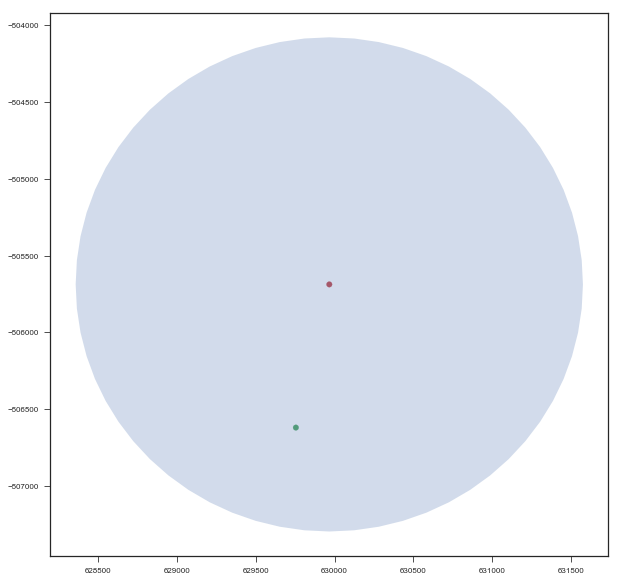

In [84]:
y, z = x

w = np.array([(uni_gdf.loc[int(l)].geometry.xy[0][0]) for l in z])
p = np.array([(uni_gdf.loc[int(l)].geometry.xy[1][0]) for l in z])
w = np.append(w, tract_centroids_gdf.loc[y].geometry.xy[0][0])
p = np.append(p, tract_centroids_gdf.loc[y].geometry.xy[1][0])

colors = ['g' for i in range(len(p) - 1)] + ['r']

fig, axs = plt.subplots(figsize=(10, 10))
axs.fill(tract_centroids_gdf.loc[y].geometry.buffer(BUFFER).exterior.coords.xy[0], 
         tract_centroids_gdf.loc[y].geometry.buffer(BUFFER).exterior.coords.xy[1], alpha=.25, fc='b', ec='none')
axs.scatter(w, p, c=colors);

In [85]:
# Store centroid BUFFER dict of universities to file
# with open('./datasets/tract_universities.json', 'w') as fp:
#     json.dump(tract_universities, fp)

In [86]:
# Create a dictionary of number of universities accessible to each census tract
num_accessible_unis = {geoid: len(unis) for geoid, unis in tract_universities.items()}

In [87]:
# Creating Pandas Dataframe from dictionary
education_deserts = pd.DataFrame.from_dict(num_accessible_unis, orient='index', columns=['Number of Accessible Universities'])
education_deserts['Education Desert'] = 0
education_deserts.loc[education_deserts['Number of Accessible Universities'] == 0, 'Education Desert'] = 1
education_deserts.head()

,Number of Accessible Universities,Education Desert
29001950900,1,0
29007950100,0,1
29009960100,0,1
29019001201,0,1
29021000600,0,1


In [88]:
print('Number of Education Deserts in our dataset: {}'.format(len(education_deserts[education_deserts['Education Desert'] == 1])))
print('Number of Non-Education Deserts in our dataset: {}'.format(len(education_deserts[education_deserts['Education Desert'] == 0])))

Number of Education Deserts in our dataset: 69467
Number of Non-Education Deserts in our dataset: 4407


In [89]:
# Write to csv file
# education_deserts.to_csv(r'./datasets/education_deserts.csv')